In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from Utils.loading import *
from Utils.treino import *
from Utils.init_redes import *
from Utils.KD import *
from Utils.ensemble import *
from Utils.redes import *
from Utils.data_set import *
from Utils.cobertura import *
from Utils.graficos import *

cuda


# DATA SET

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

imagenet_val = torchvision.datasets.ImageNet(root= "/data", split='val', transform=transform)
val_loader = torch.utils.data.DataLoader(imagenet_val, batch_size=64, shuffle=False, num_workers=4)

# CARREGANDO UMA RESNET50 PRE TREINADA

In [3]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model = model.to("cuda")
model.eval()
print()

# TESTANDO O MODELO

In [4]:
def testa_rede(model, val_loader):
    # Calcula a acuracia da rede
    model.eval()
    correct = 0
    total = 0
    uncs_cat = torch.tensor([])
    labels_cat = torch.tensor([])
    predict_cat = torch.tensor([])
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in val_loader:
            # calculate outputs by running images through the network
            outputs = model(images.to("cuda"))
            outputs = torch.nn.functional.softmax(outputs, dim=-1)
            outputs = outputs.to("cpu")
            outputs_numpy = outputs.to("cpu").numpy()
            
            # the class with the highest energy is what we choose as prediction
            uncs_aux, predicted = torch.max(outputs.data, 1)
            
            uncs_cat = torch.cat((uncs_cat,uncs_aux),dim=0) # Junta as uncs
            labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas
            predict_cat = torch.cat((predict_cat,predicted),dim=0) # Junta as respostas
            
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    acuracia = round(100 * correct / total,3)
    return acuracia, uncs_cat.to("cuda"), labels_cat.to("cuda"), predict_cat.to("cuda")

In [5]:
acc, uncs, labels, predict = testa_rede(model,val_loader)
AURC_teste, curvaRC_teste = AURC(predict.to("cuda"), labels.to("cuda"), uncs, return_curve=True)
AUROC_teste, fpr, tpr = AUROC(predict.to("cuda"), labels.to("cuda"), -uncs, return_curve=True)

Acuracia: 80.346 AURC 0.07573587706290957 AUROC: 0.8082156267204279


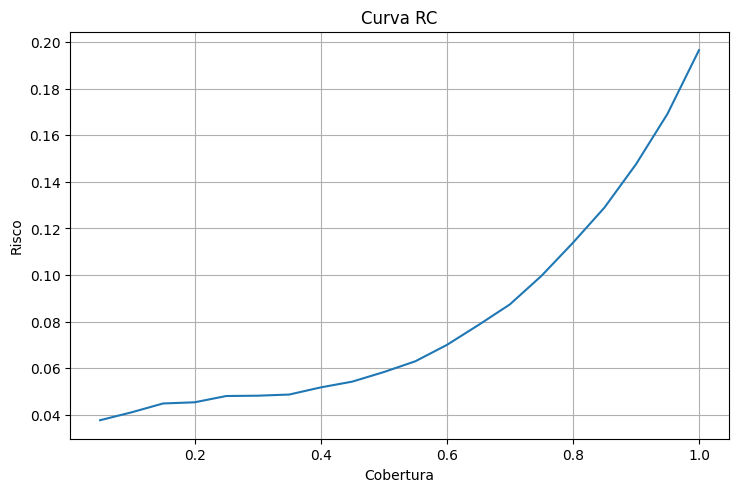

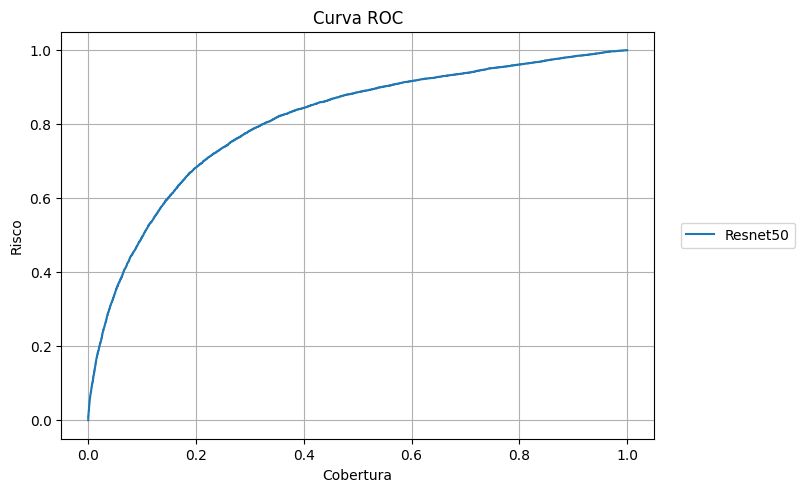

In [11]:
C = np.arange(0.05,1.05,0.05)

print("Acuracia:", acc, "AURC", AURC_teste, "AUROC:", AUROC_teste)

g2 = plot_graph(C,curvaRC_teste, title="Curva RC", xlabel="Cobertura", ylabel="Risco")
g3 = plot_mutiple_graph2([fpr],[tpr], title="Curva ROC", xlabel="Cobertura", ylabel="Risco", n_graphs=1, label="Resnet50")

#g2.savefig("./Graficos/Temperatura/{}/{} Redes/CurvaRC2.jpeg".format(data_set,n_redes))

plt.show()